# Surrogates

Surrogates can be contructed in place of thermodynamic functions to reduce computational time of the KWN model. This is useful for sensitivity analysis where certain parameters need to be pertubated often.

As with the Thermodynamics module, the Surrogates module are split into two classes for binary and multicomponent systems.

## Binary Systems

Surrogates for driving force, interfacial composition and diffusivity can be created for binary systems.

Both the Binary and Multicomponent surrogates require the thermodynamic functions for the various terms. While these can be user-defined, it is easiest to use a Thermodynamics object.

In [1]:
from kawin.thermo import BinaryThermodynamics
from kawin.thermo import BinarySurrogate

#Load TDB file into a Thermodynamics object
binaryTherm = BinaryThermodynamics('AlScZr.tdb', ['AL', 'ZR'], ['FCC_A1', 'AL3ZR'])
binaryTherm.setGuessComposition(0.24)

#Create Surrogate object
binarySurr = BinarySurrogate(binaryTherm)

### Driving force

Training a surrogate model for driving forces in a binary system requires a set of compositions and temperatures (or a single temperature for isothermal systems). An additional parameter called 'scale' will convert the set of training compositions into linear or logarithmic spacing. This will allow for training on both dilute (logarithmic spacing) and non-dilute (linear spacing) systems.

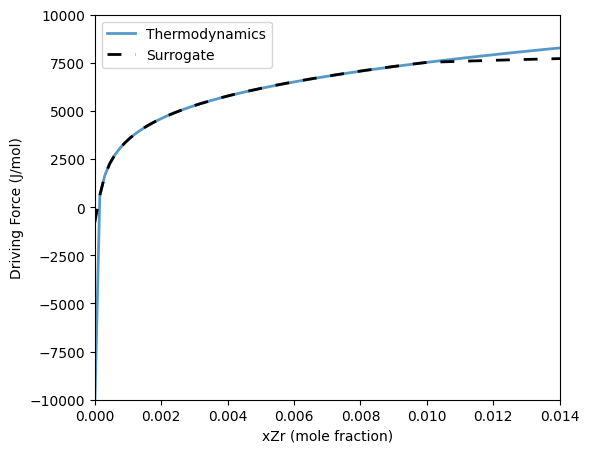

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#Train driving forces
T = 723.15
xtrain = np.logspace(-5, -2, 20)
binarySurr.trainDrivingForce(xtrain, [T], scale='log')

#Compare surrogate and thermodynamics modules
xTest = np.linspace(1e-7, 1.5e-2, 100)
binaryTherm.clearCache()
dgTherm, _ = binaryTherm.getDrivingForce(xTest, np.ones(100)*T)
dgSurr, _ = binarySurr.getDrivingForce(xTest, np.ones(100)*T)

fig1 = plt.figure(1, figsize=(6, 5))
ax1 = fig1.add_subplot(111)
ax1.plot(xTest, dgTherm, label='Thermodynamics', linewidth=2, alpha=0.75)
ax1.plot(xTest, dgSurr, label='Surrogate', color='k', linestyle=(0,(5,5)), linewidth=2)
ax1.set_xlim([0, 0.014])
ax1.set_ylim([-10000, 10000])
ax1.set_xlabel('xZr (mole fraction)')
ax1.set_ylabel('Driving Force (J/mol)')
ax1.legend()


### Interfacial composition

Training a surrogate for interfacial compositions requires a set of temperatures and free energy contributions. For the free energy contributions, it may be useful to setup the KWN model first, then calling $ KWNBase.particleGibbs(R) $ where R is a set of radii. In practice, R should encompass a larger domain than what is set for the particle size distribution in the KWN model in case the particle size distribution is updated to include large size classes during a simulation.

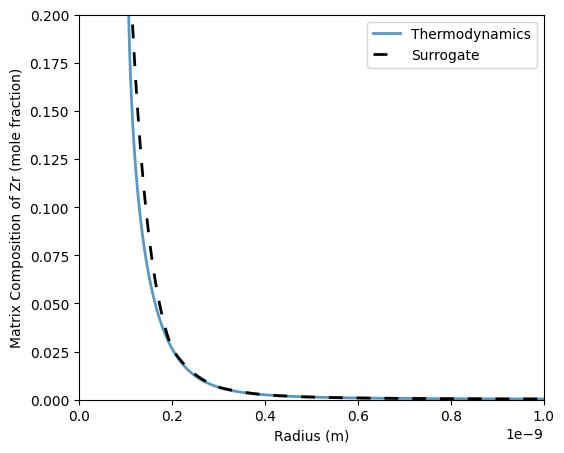

In [3]:
#Create training points
T = 723.15
gamma = 0.1
Vm = 1e-5
R = np.linspace(1e-10, 1e-8, 100)
G = 2 * gamma * Vm / R

#Train surrogate
binarySurr.trainInterfacialComposition([T], G, scale='log')

#Compare surrogate and thermodynamics modules
Gtest = np.linspace(1000, 25000, 100)
Rtest = 2 * gamma * Vm / Gtest
binaryTherm.clearCache()
xMTherm, _ = binaryTherm.getInterfacialComposition(T, Gtest)
xMSurr, _ = binarySurr.getInterfacialComposition(T, Gtest)

fig2 = plt.figure(2, figsize=(6, 5))
ax2 = fig2.add_subplot(111)
ax2.plot(Rtest[xMTherm != -1], xMTherm[xMTherm != -1], label='Thermodynamics', linewidth=2, alpha=0.75)
ax2.plot(Rtest[xMSurr != -1], xMSurr[xMSurr != -1], label='Surrogate', color='k', linestyle=(0,(5,5)), linewidth=2)
ax2.set_xlim([0, 1e-9])
ax2.set_ylim([0, 0.2])
ax2.set_xlabel('Radius (m)')
ax2.set_ylabel('Matrix Composition of Zr (mole fraction)')
ax2.legend()


### Interdiffusivity

Training a surrogate on the interdiffusivity requires a set of compositions and temperatures. If the interdiffusivity only depends on temperature, then only a single value for the composition is required.

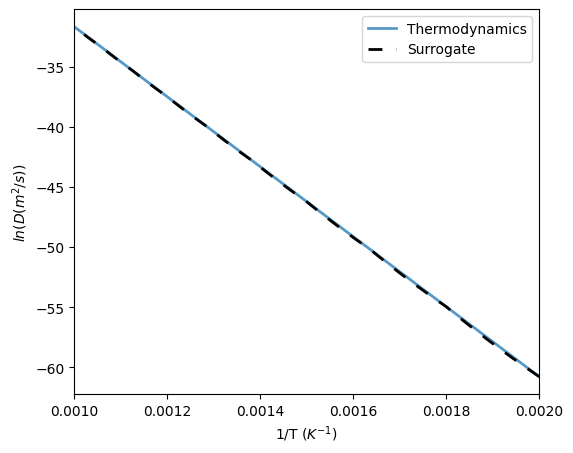

In [4]:
#Train interdiffusivity
Ttrain = np.linspace(500, 1000, 10)
binarySurr.trainInterdiffusivity([0.01], Ttrain, scale='log')

#Compare surrogate and thermodynamics modules
Ttest = np.linspace(500, 1000, 100)
binaryTherm.clearCache()
dTherm = binaryTherm.getInterdiffusivity(np.ones(100)*0.01, Ttest)
dSurr = binarySurr.getInterdiffusivity(np.ones(100)*0.01, Ttest)

fig3 = plt.figure(3, figsize=(6, 5))
ax3 = fig3.add_subplot(111)
ax3.plot(1/Ttest, np.log(dTherm), label='Thermodynamics', linewidth=2, alpha=0.75)
ax3.plot(1/Ttest, np.log(dSurr), label='Surrogate', color='k', linestyle=(0,(5,5)), linewidth=2)
ax3.set_xlim([1/1000, 1/500])
ax3.set_xlabel('1/T ($K^{-1}$)')
ax3.set_ylabel('$ln(D (m^2/s))$')
ax3.legend()

## Multicomponent Systems

Surrogates for driving force, interfacial composition, growth rate and impingement factor can be created for multicomponent systems. Note that as the interfacial composition, growth rate and impingement factor can all be determined by a single equilibrium calculation, these terms are grouped into 'curvature factors'. This is similar to how these terms are handled in the Thermodynamics module.

As with the Binary surrogates, the multicomponent surrogate object only requires a MulticomponentThermodynamics object.

In [5]:
from kawin.thermo import MulticomponentThermodynamics
from kawin.thermo import MulticomponentSurrogate

multiTherm = MulticomponentThermodynamics('NiCrAl.tdb', ['NI', 'CR', 'AL'], ['FCC_A1', 'FCC_L12'])
multiSurr = MulticomponentSurrogate(multiTherm)

### Driving force

Training a surrogate for driving force calculations requires a set of compositions and temperatures. The difference between the Binary and Multicomponent surrogate objects is that the set of compositions for a multicomponent systems is a 2D array of size m x n, where m is the number of training points and n is the number of solutes.

A utility function is provided to create a cartesian product of multiple arrays for each solute.

In [6]:
from kawin.thermo import generateTrainingPoints

#Create training points
T = 1273.15
xCr = np.linspace(0.01, 0.05, 8)
xAl = np.linspace(0.1, 0.2, 8)
xTrain = generateTrainingPoints(xCr, xAl)

#Train driving force
multiSurr.trainDrivingForce(xTrain, [T])

### Curvature factors

The growth rate, interfacial composition, interdiffusivity and impingement rate can all be determined from the curvature of the Gibbs free energy surface. Thus, these terms are lumped into a single group that will be referred to as 'curvature factors'. Training the curvature factors only requires a set of compositions and temperatures.

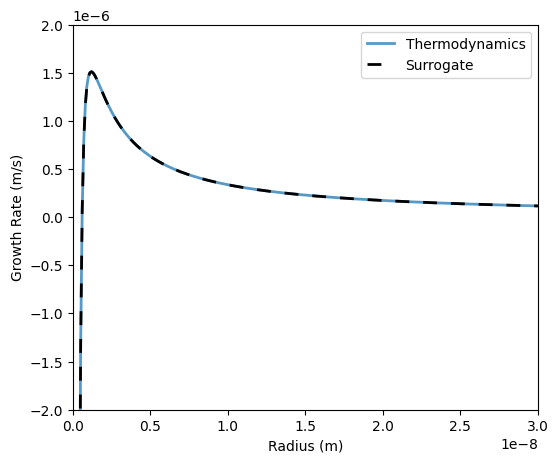

In [8]:
#Create training points
T = 1273.15
xCr = np.linspace(0.01, 0.05, 16)
xAl = np.linspace(0.1, 0.2, 16)
xTrain = generateTrainingPoints(xCr, xAl)

#Train curvature surrogate
multiSurr.trainCurvature(xTrain, T)

#Compare growth rate from surrogate and thermodynamics modules
xTest = [0.03, 0.175]    #Ni-3Cr-17.5Al

gamma = 0.023        #Interfacial energy between FCC-Ni and Ni3Al
Vm = 1e-5           #Molar volume
Rtest = np.linspace(1e-10, 3e-8, 300)
Gtest = 2 * gamma * Vm / Rtest

multiTherm.clearCache()
dgTherm, xb = multiTherm.getDrivingForce(xTest, T)
growthTherm = multiTherm.getGrowthAndInterfacialComposition(xTest, T, dgTherm, Rtest, Gtest, searchDir=xb)

dgSurr, _ = multiSurr.getDrivingForce(xTest, T)
growthSurr = multiSurr.getGrowthAndInterfacialComposition(xTest, T, dgSurr, Rtest, Gtest)

fig4 = plt.figure(4, figsize=(6, 5))
ax4 = fig4.add_subplot(111)
ax4.plot(Rtest, growthTherm.growth_rate, label='Thermodynamics', linewidth=2, alpha=0.75)
ax4.plot(Rtest, growthSurr.growth_rate, label='Surrogate', color='k', linestyle=(0,(5,5)), linewidth=2)
ax4.set_xlim([0, 3e-8])
ax4.set_ylim([-2e-6, 2e-6])
ax4.set_xlabel('Radius (m)')
ax4.set_ylabel('Growth Rate (m/s)')
ax4.legend()


## Hyperparameters

The surrogates are created through scipy's radial basis functions. The same hyperparameters used in the scipy's implementation can be used for these surrogates. These include: 'function', 'epsilon', 'smooth'. 'function' is the basis function to use, 'epsilon' is the scale between training points (the surrogates will automatically scale the training points such that the optimal value for 'epsilon' should be near 1), and 'smooth' allows for smoothing the interpolation (a value of 0 means that the surrogate will cross all training points). When training the surrogates, these are set as additional parameters. For example:

$ Surrogate.trainDrivingForce(x, T, function='linear', epsilon=1, smooth=0) $

If a surrogate is already trained, the hyperparameters can be changed without the need for re-training.

$ Surrogate.changeDrivingForceHyperparameters(function, epsilon, smooth) $

## Saving and loading

The surrogates can be saved and loaded for later usage. These will not retain the thermodynamic functions used for the training, so re-training of the surrogate cannot be done after saving/loading; however, the hyperparameters can still be changed.

$ Surrogate.save(filename) $

$ surr = Surrogate.load(filename) $

## Usage in the KWN Model

As with the Thermodynamics module, the Surrogate objects can be easily used in the KWN model by:

$ KWNModel.setSurrogate(Surrogate) $

For binary systems, the interdiffusivity also has to be inputted separately.

$ KWNModel.setDiffusivity(BinarySurrogate.getInterdiffusivity) $